# 1. Mount Google Drive & Baca Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/My Drive/Semester 6/Machine Learning/Dataset/chatgpt_user_feedback.csv'
df = pd.read_csv(file_path)
df.head()

Mounted at /content/drive


,Unnamed: 0,userName,content,score,thumbsUpCount,at
0,0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0,28-06-2024 21:07
1,1,Muhammad bassam adam,perfect,5,0,28-06-2024 20:56
2,2,Chinaza Okoli,its been so helpful...love it,5,0,28-06-2024 20:54
3,3,Project House Group Ltd,It's amazing tools help me a lot with my work.,5,0,28-06-2024 20:51
4,4,Safoan Riyad,I enjoyed ChatGPT. But last update ruined ever...,1,0,28-06-2024 20:50


# 2. Install dan Import Library

In [2]:
!pip install -q Sastrawi swifter

import re
import swifter
import matplotlib.pyplot as plt

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

print("✅ Semua library berhasil diimpor dan siap digunakan!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.6 MB/s eta 0:00:00
✅ Semua library berhasil diimpor dan siap digunakan!


# 3. Pra-pemrosesan

In [4]:
factory_stop = StopWordRemoverFactory()
stopword = factory_stop.create_stop_word_remover()
factory_stem = StemmerFactory()
stemmer = factory_stem.create_stemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = stopword.remove(text)
    text = stemmer.stem(text)
    return text

df.rename(columns={'content': 'review'}, inplace=True)

df['clean_review'] = df['review'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/149719 [00:00<?, ?it/s]

#4. TF-IDF Vectorization

In [5]:
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(df['clean_review'])
print("✅ TF-IDF berhasil dibuat dan fitur telah diubah ke bentuk vektor!")

✅ TF-IDF berhasil dibuat dan fitur telah diubah ke bentuk vektor!


# 5. Label Sentimen

In [6]:
df['label'] = df['score'].apply(lambda x: 1 if x >= 4 else 0)
y = df['label']

print(df['label'].value_counts())

label
1    131319
0     18400
Name: count, dtype: int64


# 6. Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Jumlah data total:", X.shape[0])
print("Jumlah data training:", X_train.shape[0])
print("Jumlah data testing:", X_test.shape[0])

print("\nDistribusi label di data training:")
print(pd.Series(y_train).value_counts())

print("\nDistribusi label di data testing:")
print(pd.Series(y_test).value_counts())

Jumlah data total: 149719
Jumlah data training: 119775
Jumlah data testing: 29944

Distribusi label di data training:
label
1    105029
0     14746
Name: count, dtype: int64

Distribusi label di data testing:
label
1    26290
0     3654
Name: count, dtype: int64


# 7. Pelatihan Model

In [8]:
model = LinearSVC()
model.fit(X_train, y_train)

print("✅ Model berhasil dilatih!")
print("Jumlah data training:", X_train.shape[0])
print("Jumlah fitur:", X_train.shape[1])

# Save the trained model and TF-IDF vectorizer
import joblib
joblib.dump(model, 'svm_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
print("✅ Model dan TF-IDF vectorizer berhasil disimpan!")

✅ Model berhasil dilatih!
Jumlah data training: 119775
Jumlah fitur: 34336
✅ Model dan TF-IDF vectorizer berhasil disimpan!



# 8. Evaluasi Model

In [9]:
y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred, target_names=["Negatif", "Positif"]))

Akurasi: 0.9154087630243121
Laporan Klasifikasi:
               precision    recall  f1-score   support

     Negatif       0.76      0.44      0.56      3654
     Positif       0.93      0.98      0.95     26290

    accuracy                           0.92     29944
   macro avg       0.85      0.71      0.76     29944
weighted avg       0.91      0.92      0.91     29944



# 9. Visualisasi

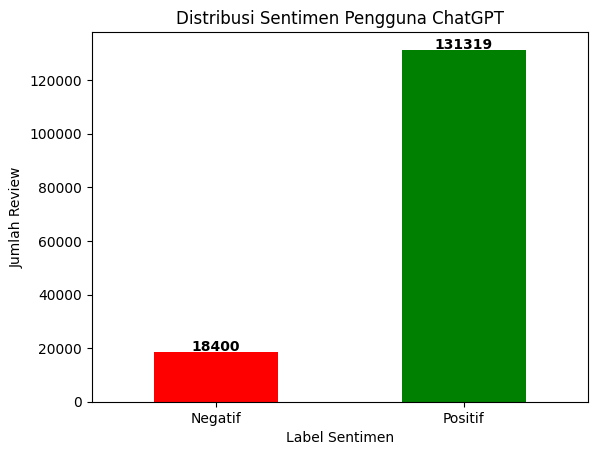

In [12]:
label_counts = df['label'].value_counts().sort_index()

for i, val in enumerate(label_counts):
    plt.text(i, val + 500, str(val), ha='center', fontweight='bold')

label_counts.plot(kind='bar', color=['red', 'green'])
plt.xticks(ticks=[0, 1], labels=['Negatif', 'Positif'], rotation=0)
plt.title("Distribusi Sentimen Pengguna ChatGPT")
plt.xlabel("Label Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

#Deployment

In [16]:
!pip install gradio

import gradio as gr

def predict_sentiment(text):
    cleaned = clean_text(text)
    vector = tfidf.transform([cleaned])
    pred = model.predict(vector)[0]
    return "Positif 😊" if pred == 1 else "Negatif 😔"

gr.Interface(
    fn=predict_sentiment,
    inputs="text",
    outputs="text",
    title="Klasifikasi Sentimen Ulasan ChatGPT"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ffcb1c6aa4591d5133.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [17]:
from google.colab import files

files.download('svm_model.joblib')
files.download('tfidf_vectorizer.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>